In [47]:
%matplotlib inline

import numpy as np
import scipy.linalg as la
import scipy.interpolate as interp
import scipy.integrate as integrate
import scipy.fftpack as fft
import scipy.stats as st
import scipy.signal as signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import numdifftools as nd
import random
from scipy.optimize import minimize
from scipy.optimize import newton
from sklearn.metrics import mean_squared_error
from scipy.optimize import approx_fprime
import math

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

default_dpi = mpl.rcParamsDefault['figure.dpi']
factor = 1.5
mpl.rcParams['figure.dpi'] = default_dpi * factor

# Тема 1. Интерполяция в полиномиальных базисах

## 1.1 Интерполяция полиномами

Рассмотрим систему несовпадающих точек $$ x_{i} ({\displaystyle i\in {0,1,\dots ,N}})$$ из некоторой области D. Пусть значения функции $f$ известны только в этих точках:

Задача интерполяции состоит в поиске такой функции $F$ из заданного класса функций, что

  $$F(x_{i})=y_{i},\quad i=1,\ldots ,N$$

  1. Точки $x_{i}$ называют узлами интерполяции, а их совокупность — интерполяционной сеткой.
  2. Пары ${\displaystyle (x_{i},y_{i})}$ называют точками данных или базовыми точками.
  3. Разность между «соседними» значениями ${\displaystyle \Delta x_{i}=x_{i}-x_{i-1}}$ — шагом интерполяционной сетки. Он может быть как переменным, так и постоянным.
  4.  Функцию $F(x)$ — интерполирующей функцией или интерполянтом.
  
Интерполяция выражается с помощью интерполяционных многочленов. Например, с помощью многочлена Лагранжа:
Интерполяцио́нный многочле́н Лагра́нжа — многочлен минимальной степени, принимающий данные значения в данном наборе точек. Для n+1 пар чисел $(x0, y0), (x1, y1),…, (xn, yn)$, где все xj различны, существует единственный многочлен $L(x)$ степени не более n, для которого $L(x_{j}) = y_{j}$. 
Лагранж предложил способ вычисления таких многочленов:
$$L(x)=\sum _{{i=0}}^{n}y_{i}l_{i}(x)$$

где базисные полиномы определяются по формуле:

 $${\displaystyle l_{i}(x)=\prod _{j=0,j\neq i}^{n}{\frac {x-x_{j}}{x_{i}-x_{j}}}={\frac {x-x_{0}}{x_{i}-x_{0}}}\cdots {\frac {x-x_{i-1}}{x_{i}-x_{i-1}}}\cdot {\frac {x-x_{i+1}}{x_{i}-x_{i+1}}}\cdots {\frac {x-x_{n}}{x_{i}-x_{n}}}}$$

$l_{i}(x)$ обладают следующими свойствами:
  1. Являются многочленами степени n
  2. $l_{i}(x_{i}) = 1$
    l_{i}(x_{j}) = 0 при j ≠ i

Отсюда следует, что $L(x)$, как линейная комбинация $l_{i}(x)$, может иметь степень не больше $n$, и $L(x_{i}) = y_{i}$.

In [4]:
def lagrange(x,y,t):
    z=0
    for j in range(len(y)):
        p = 1
        for i in range(len(x)):
            if i!=j:
                p=p*(t-x[i])/(x[j]-x[i])
        z=z+y[j]*p
    return z

## Сформируем набор данных

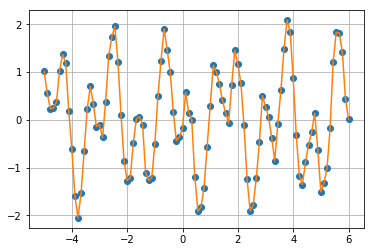

In [5]:
def myfunc(x):
    n = len(x)
    
    #y = [-0.6*(np.cos(x1 * 2.5)*2.5*np.sin(2*x1) + 1.2*np.exp(0.4*x1)) for x1 in x]
    y = [2*(np.sin(x1 * 2)*np.cos(x1 * 5)) for x1 in x]
    
    random.seed(7)
    Delta1 = 0.15 * np.random.randn(n) 
    return list(y+Delta1)

x = np.linspace(-5, 6, 100)
y = myfunc(x)
xnew=np.linspace(np.min(x),np.max(x),100)
ynew=[lagrange(x,y,i) for i in xnew]
plt.plot(x,y,'o',xnew,ynew)
plt.grid(True)
plt.show()

## 1.2 Интерполяция сплайнами

Сплайн - многочлен степени не выше трех: $S_i(x) = a_i+b_i*x+c_i*x^2+d_i*x^3$
<br>
В узлах сплайна выполняется условие: $S_i(x_i)=y_i$ 
<br>
Во внутренних узлах сплайн имеет непрерывные первую и вторую производные: $S_i'(x_i)=S_{i-1}(x_i)$ и $S_i''(x_i)=S_{i-1}(x_i)$
<br>

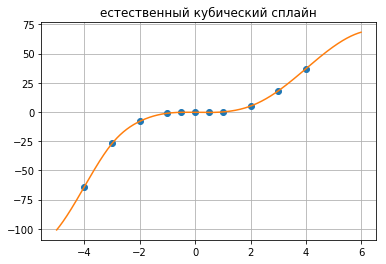

In [15]:
cubic = interp.CubicSpline(x, y, bc_type='natural')
x_d = np.arange (-5, 6, 0.01)
plt.grid()
plt.title('естественный кубический сплайн') #вторые производнын на краях  = 0
plt.plot(x, y, 'o')
plt.plot(x_d, cubic(x_d))

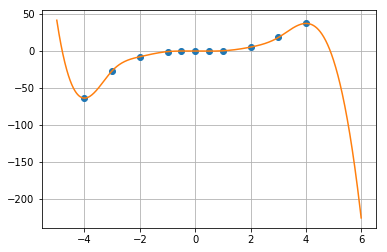

In [16]:
cubic = interp.CubicSpline(x, y, bc_type='clamped')
plt.grid()
plt.plot(x, y, 'o')
plt.plot(x_d, cubic(x_d))

# Тема 2. Сглаживающая аппроксимация в полиномиальных базисах

## Тема 2.1. Матрично-векторная формулировка

Для аппроксимации данных используется метод наименьших квадратов. Задача заключается в нахождении коэффициентов линейной зависимости, при которых функция двух переменных $F(a, b)=\sum _{{i=1}}^{n}(y_{i}-(ax_{i}+b))^{2}$ принимает наименьшее значение. То есть, при данных а и b сумма квадратов отклонений экспериментальных данных от найденной прямой будет наименьшей. В этом вся суть метода наименьших квадратов.

 Составляется и решается система из двух уравнений с двумя неизвестными.
 
    $$
{\displaystyle {\begin{pmatrix}n&\sum _{t=1}^{n}x_{t}\\\sum _{t=1}^{n}x_{t}&\sum _{t=1}^{n}x_{t}^{2}\\\end{pmatrix}}{\begin{pmatrix}a\\b\\\end{pmatrix}}={\begin{pmatrix}\sum _{t=1}^{n}y_{t}\\\sum _{t=1}^{n}x_{t}y_{t}\\\end{pmatrix}}}.$$


Решаем полученную систему уравнений любым методом (например методом подстановки или методом Крамера) и получаем формулы для нахождения коэффициентов по методу наименьших квадратов (МНК).
 $${\displaystyle {\begin{cases}{\hat {b}}={\frac {n\sum _{t=1}^{n}x_{t}y_{t}-\left(\sum _{t=1}^{n}x_{t}\right)\left(\sum _{t=1}^{n}y_{t}\right)}{n\sum _{t=1}^{n}x_{t}^{2}-\left(\sum _{t=1}^{n}x_{t}\right)^{2}}},\\{\hat {a}}={\frac {\sum _{t=1}^{n}y_{t}-{\hat {b}}\sum _{t=1}^{n}x_{t}}{n}}.\end{cases}}}$$


Определим базовые функции:

In [194]:
def BasicFunctions (num, x):
    PhiFun = x**num
    return PhiFun
def MSE (x, y, m):
    global G, Phi
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    G = PhiT @ Phi
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return Phi, a
def AppError (x,y,Coefs):
    
    PolynomValue = np.zeros(len(x))
    for i in range (0, m+1):
        PolynomValue += Coefs[i]*x**i
   
    y_av = sum(y)/len(x)
    y_disp = sum((y-y_av)**2)/len(x)
    
    ResLocal = (y - PolynomValue)
    ResLocalRel = ResLocal/y_disp**0.5
    ResGlobal = (np.sum ((ResLocal)**2)/len(x))**0.5
    ResGlobalRel = ResGlobal / y_disp**0.5
    
    return ResLocal, ResLocalRel, ResGlobal, ResGlobalRel

## Формирование набора данных

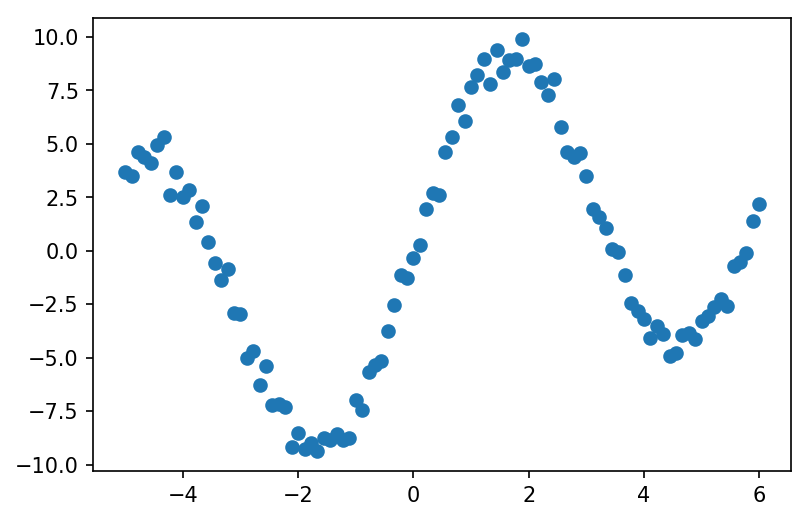

In [195]:
def myfunc(x):
    n = len(x)
    
    y = [0.75*x1 + 8*np.sin(x1) for x1 in x]
    
    random.seed(5)
    Delta1 = 0.5 * np.random.randn(n) 
    return list(y+Delta1)

x = np.linspace(-5, 6, 100)
y = myfunc(x)

plt.plot(x, y, 'o')

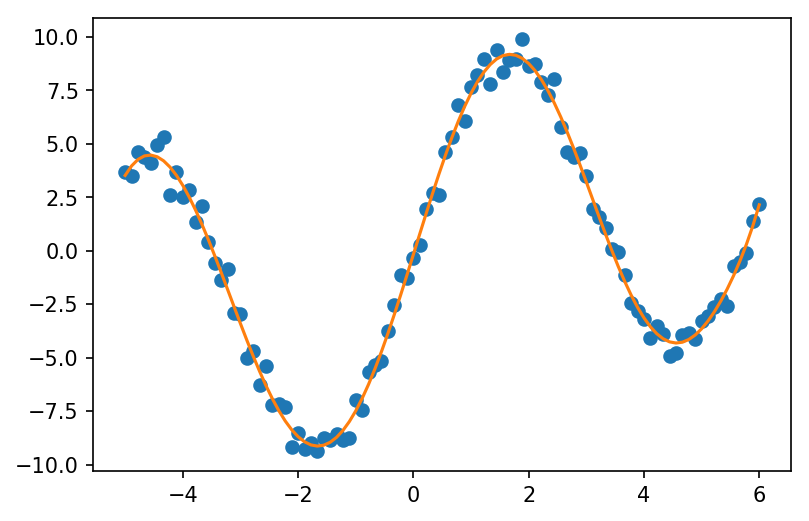

In [207]:
m = 10

PolynomCoefs = MSE(x, y, m)[1]

PolynomValue = np.zeros(len(x))

for i in range (0, m+1):
    PolynomValue += PolynomCoefs[i]*x**i
    
plt.plot (x, y, 'o')
plt.plot (x, PolynomValue)

Погрешность аппроксимации
0.5021393922065461 0.0922083810281448


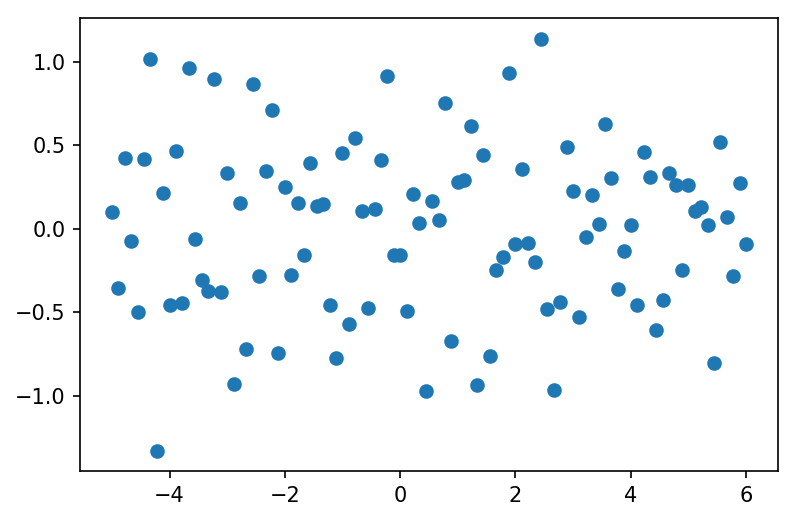

In [199]:
ResLocal, ResLocalRel, ResGlobal, ResGlobalRel = AppError (x,y,PolynomCoefs)
plt.plot (x, ResLocal, 'o')
print ('Погрешность аппроксимации')
print (ResGlobal, ResGlobalRel)

## Тема 2.2. Проблема обусловленности и борьба с ней при помощи регуляризации. 

Число обусловленности определяет, насколько погрешность входных данных может повлиять на решение системы. 
$ \mu = ||(\Phi^T \Phi)^{-1}||*||(\Phi^T \Phi)||$

In [201]:
def SqLeastReg (x, y, m, alpha):
    global G
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    
    RegAlpha = np.eye (m+1) * alpha
        
    G = PhiT @ Phi + RegAlpha 
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a

Коэффициенты МНК с регуляризацией [-1.22570909e-01  8.33270216e+00  4.39628464e-02 -1.16388379e+00
 -4.00116075e-03  4.58531119e-02  9.12842143e-05 -5.51642672e-04]


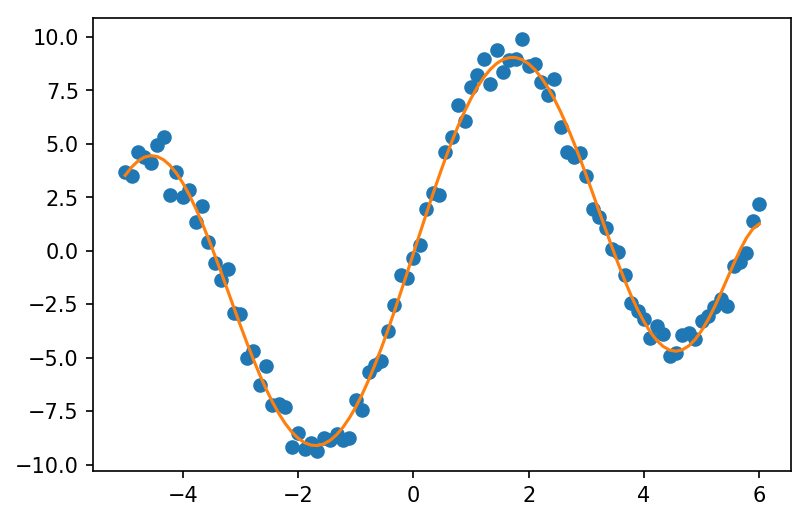

In [210]:
m = 7

CoefsReg = SqLeastReg (x, y, m, 0.01)
print ('Коэффициенты МНК с регуляризацией', CoefsReg)

PolynomValue = np.zeros(len(x))

for i in range (0, m+1):
    PolynomValue += CoefsReg[i]*x**i
    
plt.plot (x, y, 'o')
plt.plot (x, PolynomValue)

Погрешность аппроксимации
0.5059344603598497 0.09290527335672685


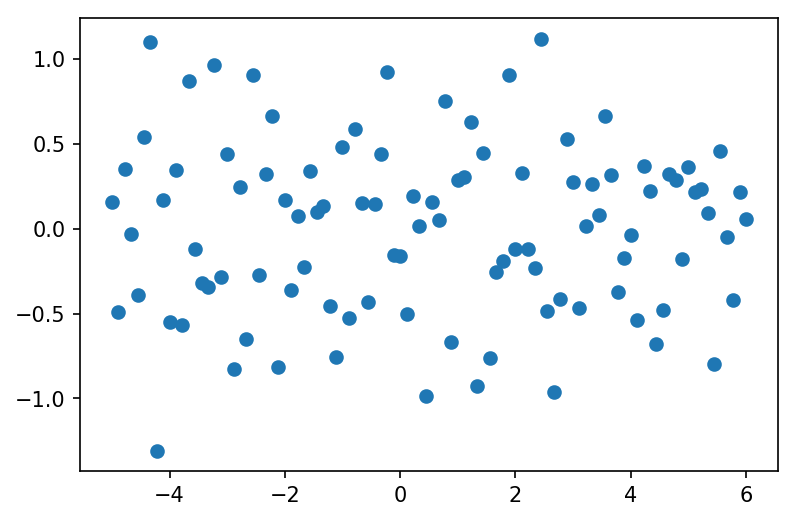

In [206]:
ResLocal, ResLocalRel, ResGlobal, ResGlobalRel = AppError (x,y,CoefsReg)
plt.plot (x, ResLocal, 'o')
print ('Погрешность аппроксимации')
print (ResGlobal, ResGlobalRel)

## Тема 2.3. Робастная аппроксимация

Представляет собой аппроксимационное сглаживание в виде итерационного процесса

In [24]:
def SqLeastRobust (x, y, m):
    n = len(x)
    yr = np.eye (n)
    E = np.eye (n)
    Phi, a = MSE(x,y, m)
    PhiT = Phi.T
    dist = 1.5
    
    yr = y @ E 
    
    eps = 0.0001
    
    # итерационный процесс
    
    print ()
    print ('Итерационный процесс')
    print ()
    
    for it in range (0, 10):
    
        ait = a  
          
        PhiA = Phi @ a
    
        res = Phi @ a - yr        
          
        for i in range (0, n):
            if (res[i]>dist):
                yr[i] = PhiA[i]-dist
            if (res[i]<-dist):
                yr[i] = PhiA[i]+dist
                    
        z = PhiT @ yr
        a = np.linalg.solve(G, z)
        
        eit = a - ait
        epsit = (sum(eit**2))**0.5/len(eit)
        
        print ('iteration', it, a, epsit)
        
        if (epsit<=eps):
            print ()
            break 
                
    return a


Итерационный процесс

iteration 0 [ 1.05173557e-01  8.45010306e+00  2.25295906e-02 -1.17612023e+00
 -4.66242848e-03  4.62665342e-02  1.35207999e-04 -5.58324157e-04] 0.0



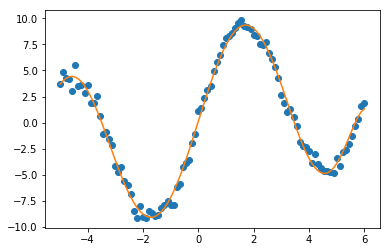

In [25]:
m = 7

PolynomCoefs = SqLeastRobust(x, y, m)

PolynomValue = np.zeros(len(x))

for i in range (0, m+1):
    PolynomValue += PolynomCoefs[i]*x**i
    
plt.plot (x, y, 'o')
plt.plot (x, PolynomValue)

## Тема 3. Статистическая обработка данных

## Сгенерируем выборку

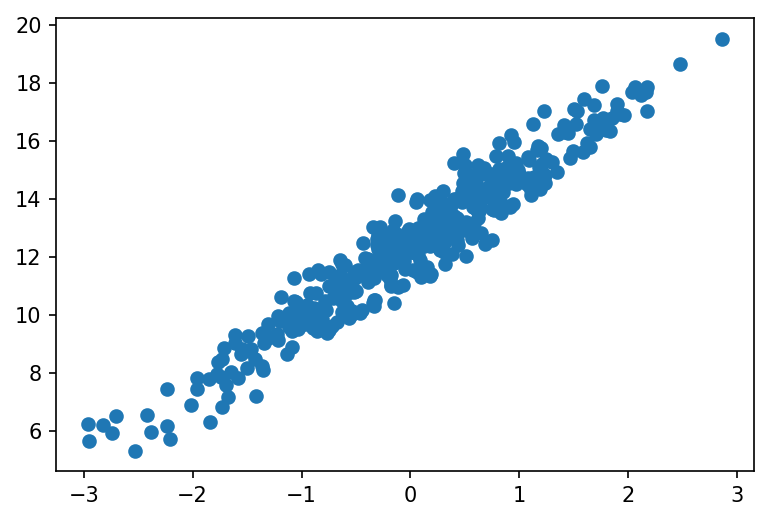

In [108]:
N = 400
m = 1
x = np.random.randn(N)

y = 12.4+x*2.5

Delta = 0.7 * np.random.randn(N)
y = y + Delta
plt.plot (x,y, 'o')

Посчитаем статистические коэффциенты регрессии:  $\widehat b_0 \: и \: \widehat b_1 $

In [109]:
Coeffs = MSE(x,y,m)[1]
Coeffs

array([12.41933557,  2.48326143])

In [110]:
a0 = Coeffs[0]
a1 = Coeffs[1]
a0,a1

(12.419335567020346, 2.4832614302951117)

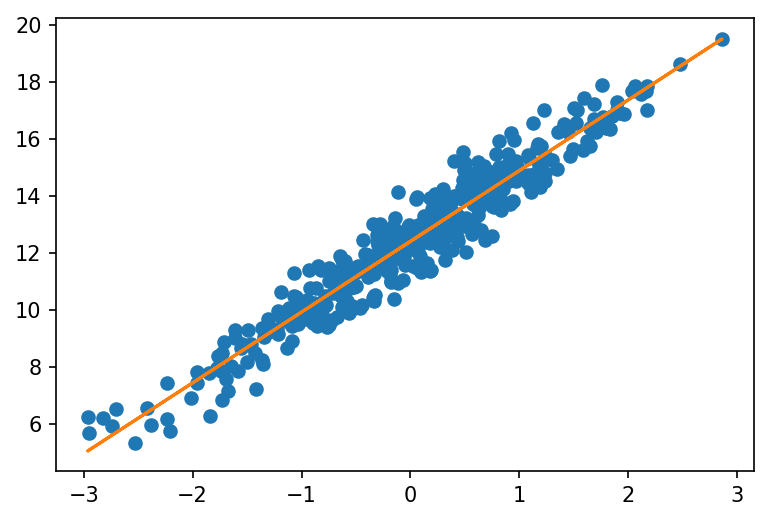

In [111]:
y_pred = np.zeros(len(x))
for i in range (0, m+1):
    y_pred += Coeffs[i]*x**i
plt.plot (x, y, 'o')
plt.plot (x, y_pred)

Найдем выборочную дисперcию остатков: 
$$S^2 = \frac{\sum_{i=1}^n(Y_i-\widehat{Y_i})^2}{n-2}$$

In [112]:
n = len(y)
standDev = (sum((y_pred-np.mean(y))**2))/(len(y)-1)
standDevA0 = standDev/(sum((x-np.mean(x))**2))
standDevA1 = standDevA0*np.sqrt(np.mean(x))
standDevA1

0.001138869945670776

Используя S надем оценки дисперсий для  $\widehat b_0 \: и \: \widehat b_1 $:
$${S_{b_0}}^2 = S^2 \frac{\sum_{i=1}^n(X_i)^2}{n\sum_{i=1}^n(X_i-\bar X)^2} $$

In [113]:
meanY = [y.mean()]*n
standev_b0 = np.sum(((np.array(y_pred)-np.array(y))**2))/(n-2)
np.round(standev,6)

0.486442

$${S_{b_1}}^2 =  \frac{S^2}{\sum_{i=1}^n(X_i-\bar X)^2} $$

In [114]:
standev_b1 = standev/(np.sum((np.array(x)-np.array(X.mean()))**2))
np.round(standev_b1,7)

0.0001649

Оценим значимость полученных коэффициентов  регрессии $\widehat b_0 \: и \: \widehat b_1$ при помощи t-критерия
$$H_0: \widehat b_0 = 0 $$
$$H_1: \widehat b_0 \neq  0 $$
Примем: $\alpha = 0.05$
$$t_{b_0} = \frac{\widehat b_0}{S_{b_0}}$$

In [115]:
t_b0 = PolynomCoefs[0]/np.sqrt(standev_b0)
print('t-статистика для b0  = ',np.round(t_b0,6),'<',np.round(st.t.ppf(0.95, len(X)-1),6), ',cледовательно, нулевая гипотеза о незначимости коэффициента принимается')

t-статистика для b0  =  0.020522 < 1.652547 ,cледовательно, нулевая гипотеза о незначимости коэффициента принимается


$$H_0: \widehat b_1 = 0 $$
$$H_1: \widehat b_1 \neq  0 $$

In [116]:
t_b1 = PolynomCoefs[1]/np.sqrt(standev_b1)
print('t-статистика для b1  = ',np.round(t_b1,6),'>',np.round(st.t.ppf(0.95, len(X)-1),6),'cледовательно нулевая гипотеза о незначимости коэффициента отвергается')

t-статистика для b1  =  673.179023 > 1.652547 cледовательно нулевая гипотеза о незначимости коэффициента отвергается


Построим доверительные интервалы для  $\widehat b_0 \: и \: \widehat b_1$ :

Для коэффициента  b0 $$(\widehat{b_0} - t_{1-\alpha/2, n-2}*S_{b_0}, t_{1-\alpha/2, n-2}*S_{b_0} + \widehat{b_0})$$

In [117]:
print('для b0  =', PolynomCoefs[0],"доверительный интервал (",PolynomCoefs[0]-(np.sqrt(standev_b0)*st.t.ppf(0.95, len(X)-2)),',',PolynomCoefs[0]+(np.sqrt(standev_b0)*st.t.ppf(0.95, len(X)-2)),")")

для b0  = 0.014241574140474864 доверительный интервал ( -1.1325703673395935 , 1.1610535156205433 )


Для коэффициента  b1 $$(\widehat{b_1} - t_{1-\alpha/2, n-2}*S_{b_1}, t_{1-\alpha/2, n-2}*S_{b_1} + \widehat{b_1})$$

In [118]:
print('для b1  =', PolynomCoefs[1],"доверительный интервал (",PolynomCoefs[1]-(np.sqrt(standev_b1)*st.t.ppf(0.95, len(X)-2)),',',PolynomCoefs[1]+(np.sqrt(standev_b1)*st.t.ppf(0.95, len(X)-2)),")")

для b1  = 8.644152937037145 доверительный интервал ( 8.622932423957815 , 8.665373450116475 )


Получим матрицу ковариации:

In [119]:
CovM = np.cov(x,y)
CovM

array([[1.02977533, 2.55720135],
       [2.55720135, 6.83055919]])

Найдем коэффициент детерминации по формуле:
$$R^{2} = \frac {||\hat{y} - \bar{y} || ^{2} }{||y - \bar{y} || ^{2}}$$

In [120]:
R2 = (sum((y_pred-np.mean(y))**2))/(sum((y-np.mean(y))**2))
R2

0.929674908591335

Найдем коэффициент корреляции Пирсона:
$$r_{xy} = \frac {\sum_{i=1}^{m} \left( x_i-\bar{x} \right)\left( y_i-\bar{y} \right)}{\sqrt{\sum_{i=1}^{m} \left( x_i-\bar{x} \right)^2 \sum_{i=1}^{m} \left( y_i-\bar{y} \right)^2}} = \frac {cov(x,y)}{\sqrt{s_x^2 s_y^2}}$$

In [121]:
Rxy = st.pearsonr(x, y)
Rxy

(0.9641965093233508, 1.5575028232903572e-231)

In [122]:
c = np.cov(Coeffs)
print(c)

49.36278462525006


In [123]:
st.shapiro(y-y_pred)

(0.9955763816833496, 0.31957587599754333)

Посмотрим на остатки модели:

In [124]:
res = np.array(y)-np.array(y_pred)

(0.695317433567043, 1.448841748237874e-15, 0.9982924810647495)

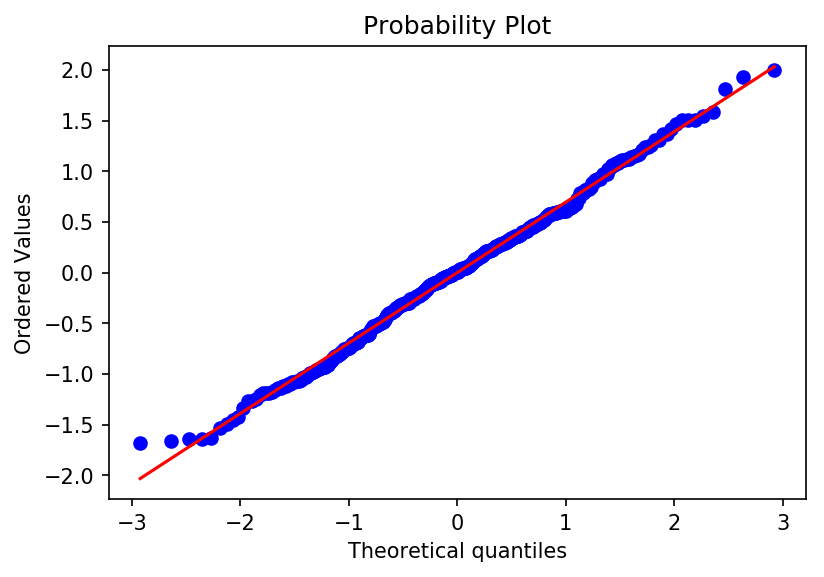

In [125]:
st.probplot(res, plot=plt)[1]

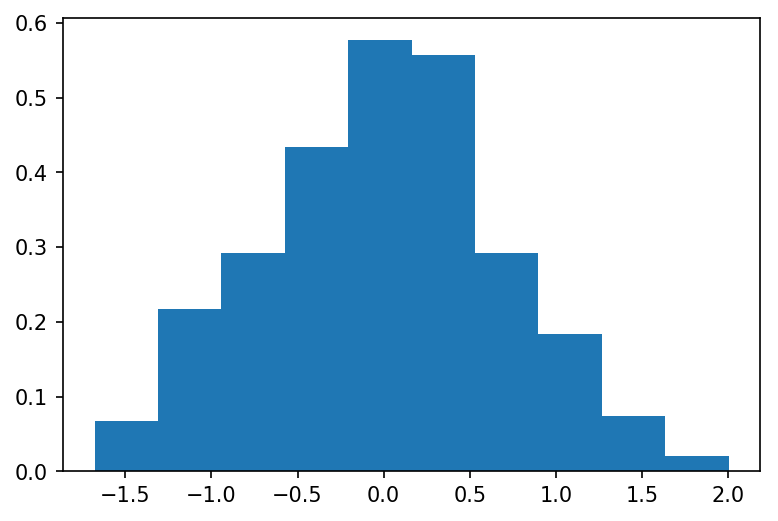

In [126]:
plt.hist(res, bins=10, density = 1);

## Тема 4. Спектральный анализ

Полезная статья по ДПФ : https://habr.com/ru/post/196374/

https://adamsiembida.com/how-to-compute-the-ifft-using-only-the-forward-fft/

## Исходные данные

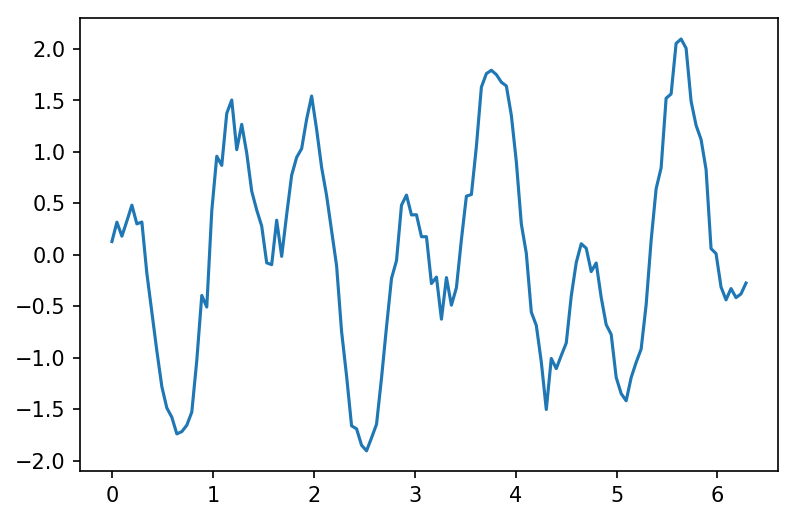

In [74]:
def myfunc(x):
    n = len(x)
    
    #y = [-0.6*(np.cos(x1 * 2.5)*2.5*np.sin(2*x1) + 1.2*np.exp(0.4*x1)) for x1 in x]
    y = [2*(np.sin(x1 * 2)*np.cos(x1 * 5)) for x1 in x]
    
    random.seed(7)
    Delta1 = 0.15 * np.random.randn(n) 
    return list(y+Delta1)

x = np.linspace(0, np.pi * 2, 128)
y_without_noise = [2*(np.sin(x1 * 2)*np.cos(x1 * 5)) for x1 in x]
y = myfunc(x)

plt.plot(x, y)

Прямое преобразование Фурье находится по формуле:$$X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N}$$
Или же в матричном виде: $$\vec{X} = M \cdot \vec{x}$$
Где матрица М : $$M_{kn} = e^{-i~2\pi~k~n~/~N}$$

In [75]:
def DFT(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

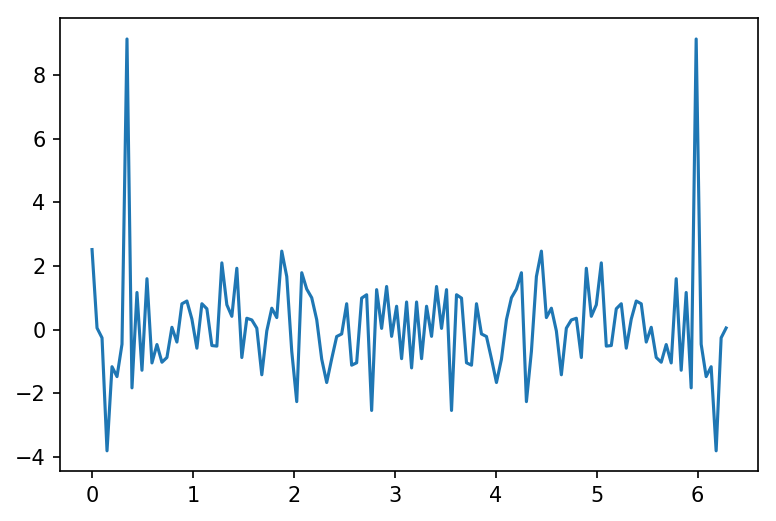

In [76]:
yf = DFT(y)
npyf = np.fft.fft(y)
plt.figure ()
#plt.plot (x,yf)
plt.plot (x,npyf)

In [77]:
np.allclose(DFT(y), np.fft.fft(y)) #Сравниваем нашу реализацию с готовой

True

## Быстрое преобразование Фурье

In [78]:
def FFT(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N % 2 > 0:
        raise ValueError("размер массива должен составлять степень двойки")
    elif N <= 32:  # this cutoff should be optimized
        return DFT(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:int(N / 2)] * X_odd,
                               X_even + factor[int(N / 2):] * X_odd])

In [79]:
np.allclose(FFT(y), np.fft.fft(y))

True

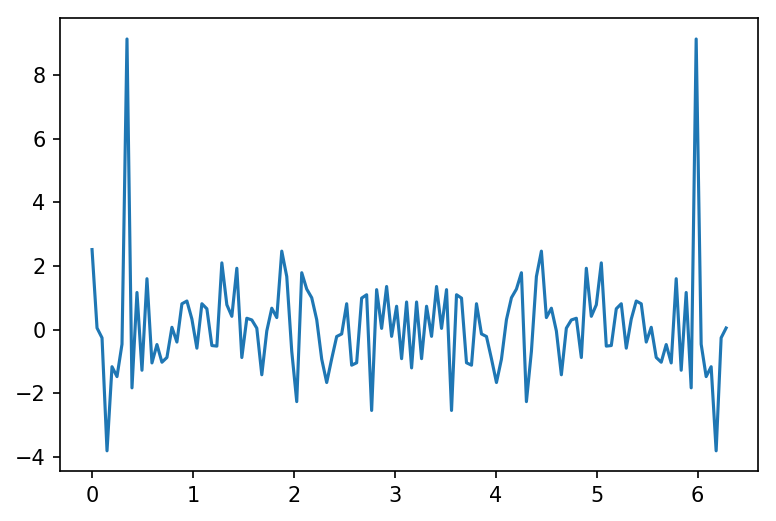

In [80]:
yf = FFT(y)
npyf = np.fft.fft(y)
plt.figure ()
#plt.plot (x,yf)
plt.plot (x,npyf)

Обратное преобразование Фурье находится по формуле:$$x_n = \frac{1}{N}\sum_{k=0}^{N-1} X_k e^{i~2\pi~k~n~/~N}$$
Также можно его представить через прямое преобразование:
   1. $$X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N} = \sum_{n=0}^\infty x_n conj(e^{j\frac{2\pi n}{N}k})$$
   2.  Используем следующее свойство сопряжения: $$ conj(a) conj(b) = conj(ab) $$
       и представим прямое преобразование следующим образом:
         $$conj(X_k) = \sum_{n=0}^\infty conj(x_n) conj(e^{j\frac{2\pi n}{N}k}) = \sum_{n=0}^\infty conj(x_n e^{j\frac{2\pi n}{N}k})$$
   3. Теперь воспользуемся следующим свойстом комплексного сопряжения:
      $$conj(a)+conj(b)=conj(a+b)$$
      Тем самым мы можем вынести операцию сопряжения за знак суммы: 
       $$conj(X_k) = conj(\sum_{n=0}^\infty x_n e^{j\frac{2\pi n}{N}k})$$
   4. Тем самым получим что:
      $$DFT_N(conj(x)) = conj(N*IDFT_N(X))$$
      Т.к. N - вещественное число, то conj(N) = N:
      $$DFT_N(conj(x)) = Nconj(IDFT_N(X))$$
      Упростим и получим, что :
      $$IFFT(X) = \frac{1}{N}conj(FFT(conj(X)))$$

In [81]:
def ifft(y):
    N = len(y)
    U = np.conjugate(y)
    u_t = np.conjugate(np.fft.fft(U))
    y_new = u_t/N
    return y_new

In [83]:
np.allclose(ifft(yf), np.fft.ifft(yf))

True

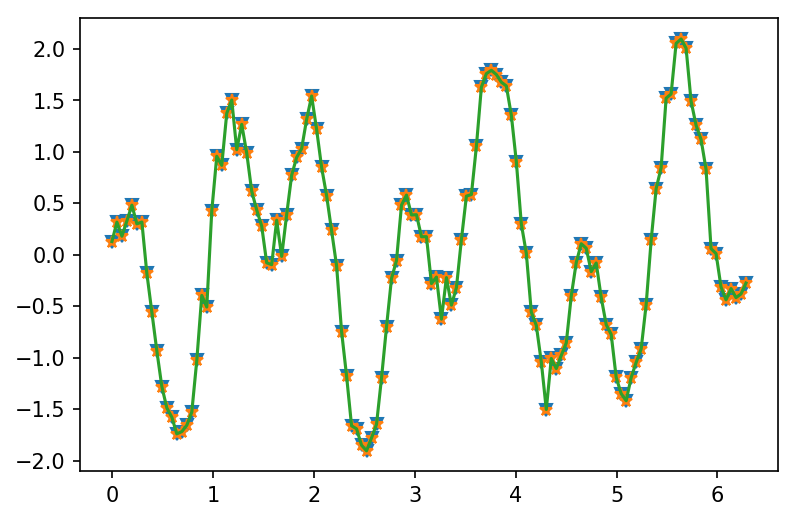

In [84]:
iy = ifft(yf)
npi = np.fft.ifft(yf)
plt.figure ()
plt.plot (x,y, 'v')
plt.plot(x,npi, '*')
plt.plot (x,iy)

## Свертка

https://en.wikipedia.org/wiki/Convolution_theorem
        Свертка это математическая операция над двумя функциями f и g, образующая 3ю функцию, которая показывает насколько одна функция изменяет другую.

   В рамках спектрального анализа дискретная свертка двух последовательностей x, y выражается как обратная функция преобразования Фурье от произведения прямого преобразования каждых двух последовательностей:
      $$x*y = IFFT(FFT(x)*FFT(y)$$

In [85]:
def convolution(y):
    n = len(y)
    W = np.zeros ((2*n))
    conv = np.zeros(n)
    W [-2] = 1./5
    W [-1] = 1./5.
    W [0] = 1./5.
    W [1] = 1./5.
    W [2] = 1./5.
    for i in range (0, n-1):
        conv [i] = 0.
        for k in range (0, n-1):
            conv[i] = conv[i] + y[k]*W[i-k]
    return conv        

In [86]:
def fft_convolution(y): 
    n = len(y)
    W = np.zeros ((n)) # Ядра свертки
    W [-2] = -1./5
    W [-1] = -1./5.
    W [0] = -1./5.
    W [1] = -1./5.
    W [2] = -1./5.
    fr=np.fft.fft(y)
    fr2=np.fft.fft(W)
    cc=np.real(ifft(fr*fr2))
    return np.fft.fftshift(cc) #Тут происходит сдвиг сигнала, так как иначе функция будет симметрична основной

In [87]:
conv = convolution(y)
conv2 = fft_convolution(y)

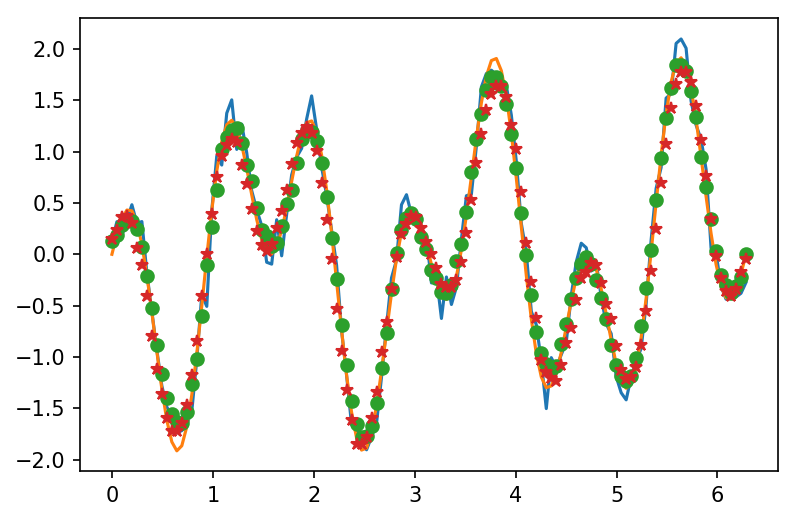

In [88]:
plt.figure ()
plt.plot (x, y)
plt.plot(x, y_without_noise)
plt.plot (x, conv, 'o')
plt.plot(x, conv2, '*')

## Автокорреляционная функция

Автокорреляционная функция — зависимость взаимосвязи между функцией (сигналом) и её сдвинутой копией от величины временного сдвига. 
Автокорреляционная функция вычисляется с помощью быстрого преобразования Фурье и прямо пропорциональна первым n элементам последовательности:
$$\psi(y) = IFFT(FFT(y)*conj(FFT(Y)))$$

In [89]:
def autocorrelation(y):
    return ifft(FFT(y) * np.conjugate(FFT(y)))

In [90]:
Ac = autocorrelation(y)

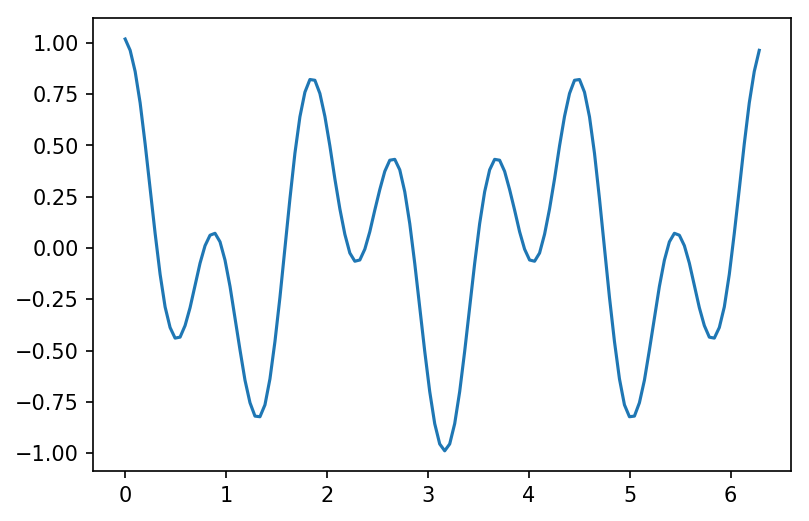

In [91]:
#plt.plot (x,y)
plt.plot (x,Ac/len(y))

## Оконное преобразование

Оконное преобразование Фурье — это разновидность преобразования Фурье, определяемая следующим образом: 
$$F(m, w) = \sum_{n=\infty}^{\infty} f(n)w(n-m)e^{-jwn}$$
Где $W(n -m)$— некоторая оконная функция

Грубо говоря, мы берем окно, которым проходим по нашей исходной функции и на каждом участке применяем прямое преобразование Фурье к исходной функции

In [92]:
def stft(x, fs, framesz, hop):
    framesamp = int(framesz*fs)
    hopsamp = int(hop*fs)
    w = np.hanning(framesamp)
    X = np.array([np.fft.fft(w*x[i:i+framesamp]) 
                     for i in range(0, len(x)-framesamp, hopsamp)])
    return X, w

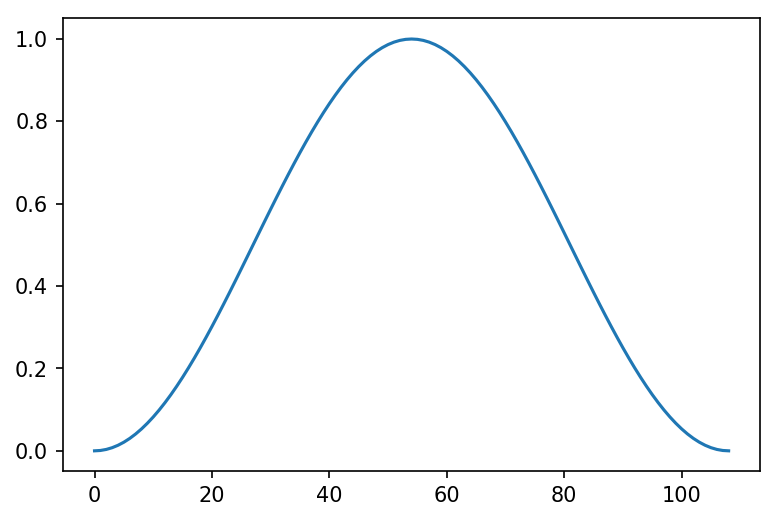

In [93]:
fs = 70 # Частота (Гц), с которой происходит проход окном
frame_size = np.pi/2  # Размер окна
hop = 2 #Размер скачков (Масштаб)
f, w = stft(y, fs, frame_size, hop)
plt.plot(w)

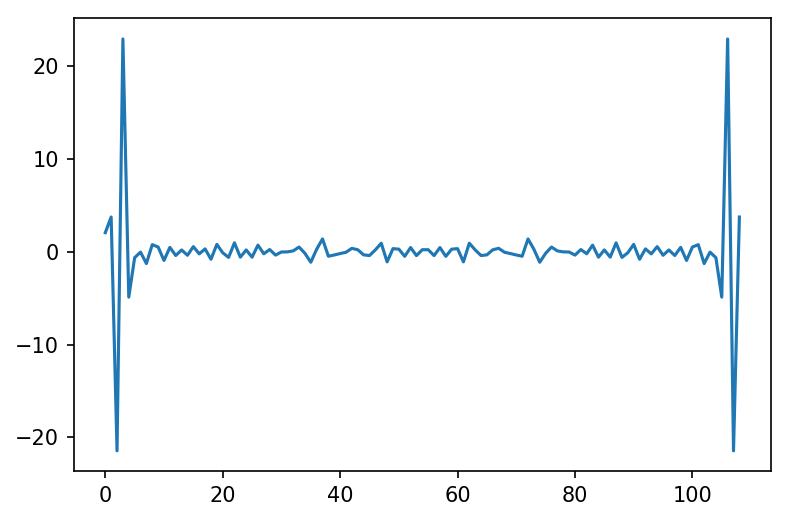

In [94]:
plt.plot (f.reshape(-1))

# Тема 5. Нелинейная аппроксимация

## Методы оптимизации

## Метод Нелдера - Мида

In [102]:
def myfunc(x):
    n = len(x)

    y = [0.6*(np.cos(x1 * 2.5) + 1.2*np.exp(0.4*x1)) for x1 in x]
    
    random.seed(5)
    Delta1 = 0.15 * np.random.randn(n) 
    return list(y+Delta1)
        
xleft = 0.05
xright = 5.0
n = 100
m = 3
X = np.linspace(xleft,xright,n)
y = myfunc(X)

Text(0,0.5,'y')

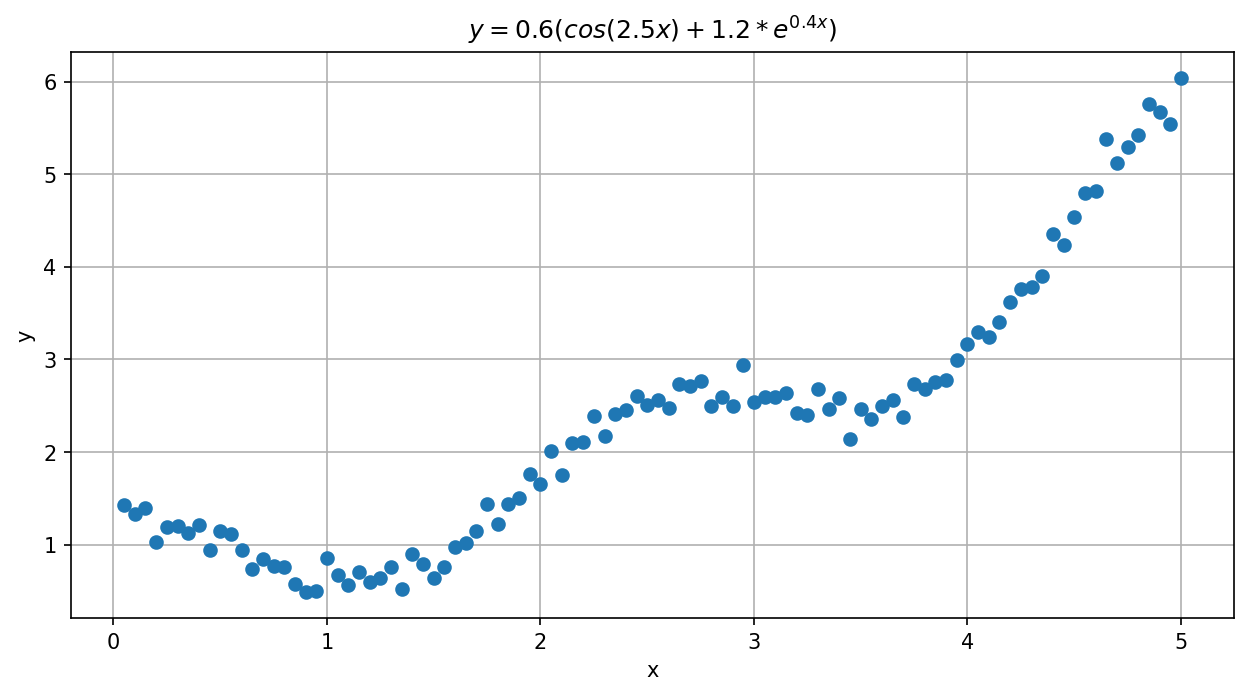

In [104]:
plt.figure(figsize=(10,5))
plt.title('$y = 0.6(cos(2.5x) + 1.2*e^{0.4x}) $')
plt.grid(True)
plt.plot (X,y, 'o')
plt.xlabel('x')
plt.ylabel('y')

Апрокисимировать неизвестную функцию, будем функцией вида: $$F(a,b,d,x) = \sum_{i=1}^3 a_i*e^{\frac{-(x-b_i)^2}{d_i}} $$
Далее определим функцию ошибки, которую будем минимизировать. 

In [8]:
def minimizefunc(x,y,el):
    return sum((y - ( x[0]*(np.exp(-(el-x[1])**2/x[2])) +
                     x[3]*(np.exp(-(el-x[4])**2/x[5])) +
                     x[6]*(np.exp(-(el-x[7])**2/x[8])) ))**2)/len(y)

## Метод Нелдера - Мида

In [67]:
x0 = [5, 3, 1, 1, 1, 3, 4, 3, 2]
res = minimize(minimizefunc, x0,args=(y,X), method='nelder-mead', options={'xtol': 1e-8, 'disp': True})

MSE = 0.026624570553882104


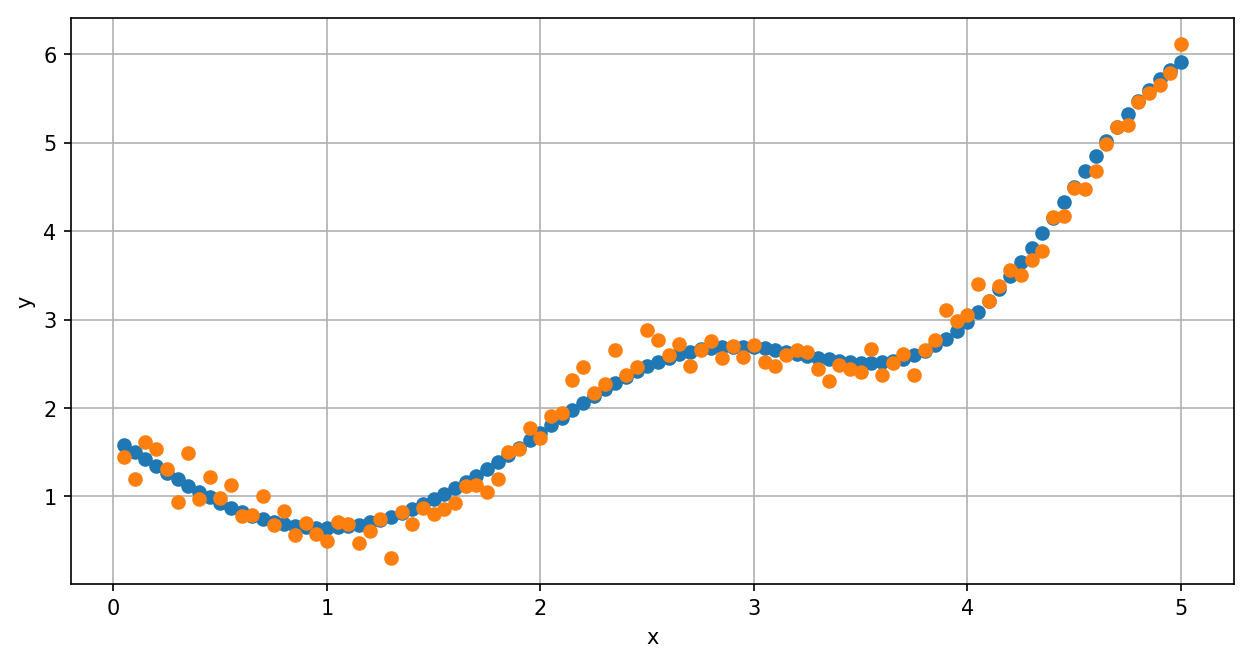

In [68]:
best_val = res.x
Y_est = (best_val[0]*np.exp(-(X-best_val[1])**2/best_val[2])) + (best_val[3]*np.exp(-(X-best_val[4])**2/best_val[5])) + (best_val[6]*np.exp(-(X-best_val[7])**2/best_val[8]))

print('MSE =', mean_squared_error(y,Y_est))

plt.figure(figsize=(10,5))
plt.title('')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.plot (X,Y_est, 'o')
plt.plot (X,y, 'o')

## Алгоритм Бройдена — Флетчера — Гольдфарба — Шанно

Напишем функцию вычисления градиента:
  $${\mathrm {grad}}\,\varphi =\nabla \varphi ={\frac {\partial \varphi }{\partial x}}{\vec e}_{x}+{\frac {\partial \varphi }{\partial y}}{\vec e}_{y}+{\frac {\partial \varphi }{\partial z}}{\vec e}_{z}$$.

In [13]:
def gradientfunc(x,y,el):
    result = []
    for coeff_i in range(0,len(x)): 
        der = 0
        if coeff_i%3==0: 
            for i in range(len(y)):
                first_part = 2*(y[i] - ( x[0]*(np.exp(-(el[i]-x[1])**2/x[2])) + x[3]*(np.exp(-(el[i]-x[4])**2/x[5])) + x[6]*(np.exp(-(el[i]-x[7])**2/x[8])))) 
                second_part = -np.exp(-(el[i]-x[coeff_i+1])**2/x[coeff_i+2])
                der = der + first_part*second_part
            der = der/len(el)
        if coeff_i%3==1: 
            for i in range(len(y)):
                first_part = 2*(y[i] - ( x[0]*(np.exp(-(el[i]-x[1])**2/x[2])) + x[3]*(np.exp(-(el[i]-x[4])**2/x[5])) + x[6]*(np.exp(-(el[i]-x[7])**2/x[8])) ))
                second_part = -x[coeff_i-1]*(2*(el[i]-x[coeff_i])/x[coeff_i+1])*np.exp(-(el[i]-x[coeff_i])**2/x[coeff_i+1])
                der = der + first_part*second_part
            der = der/len(el)
        if coeff_i%3==2:
            for i in range(len(y)):
                first_part = 2*(y[i] - ( x[0]*(np.exp(-(el[i]-x[1])**2/x[2])) + x[3]*(np.exp(-(el[i]-x[4])**2/x[5])) + x[6]*(np.exp(-(el[i]-x[7])**2/x[8])) ))
                second_part = -x[coeff_i-2]*((el[i]-x[coeff_i-1])**2/x[coeff_i]**2)*np.exp(-(el[i]-x[coeff_i-1])**2/x[coeff_i])
                der = der + first_part*second_part
            der = der/len(el) 
    
        result.append(der)
    return np.array(result)

In [15]:
x0 = [1.3, 0.9, 2.9, 1, 4.9, 1, 2.1, 1.1, 4.9]
res2 = minimize(minimizefunc, x0, method='BFGS', jac=gradientfunc,args=(y,X),options={'gtol': 1e-6,'disp': True})
best_val = res2.x
Y_est2 =   (best_val[0]*np.exp(-(X-best_val[1])**2/best_val[2])) + (best_val[3]*np.exp(-(X-best_val[4])**2/best_val[5])) + (best_val[6]*np.exp(-(X-best_val[7])**2/best_val[8]))

Optimization terminated successfully.
         Current function value: 0.016865
         Iterations: 173
         Function evaluations: 191
         Gradient evaluations: 191


MSE = 0.016865265393219017


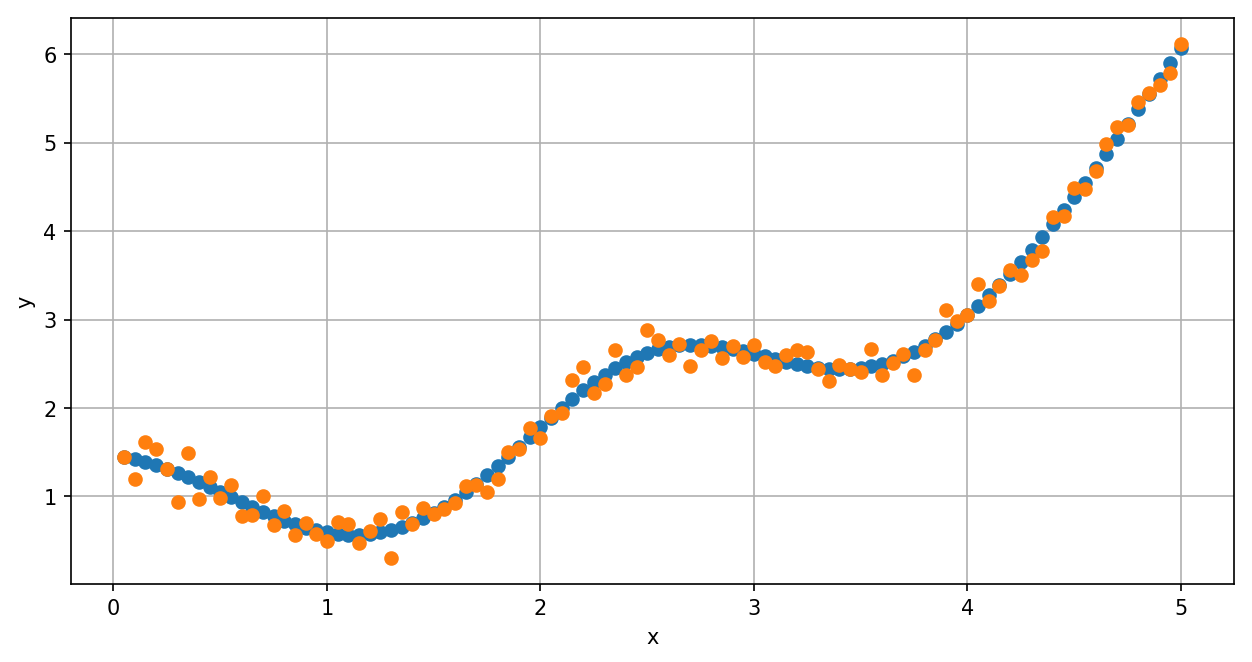

In [16]:
print('MSE =', mean_squared_error(y,Y_est2))
plt.figure(figsize=(10,5))
plt.title('')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.plot (X,Y_est2, 'o')
plt.plot (X,y, 'o')

## Метод Ньютона - Рафсона

In [28]:
def hessian(x,y,el):
    gess = np.zeros((len(x), len(x)))
    for coeff_i in range(0,len(x)): #  x это a,b,d1
        for coeff_j in range(0,len(x)):
            der  = 0    
            if (coeff_i%3==0)&(coeff_j%3==0): #производные вида aiaj
                for i in range(len(y)):
                    first_part = -np.exp(-(el[i]-x[coeff_i+1])**2/x[coeff_i+2])
                    second_part = -2*np.exp(-(el[i]-x[coeff_j+1])**2/x[coeff_j+2])
                    der = der + first_part*second_part
            if(coeff_i%3==0)&(coeff_j%3==1): #производные вида aibj
                    if (coeff_j!=coeff_i+1): #для случаев a1b2,a1b3,a2b1,a2b1,a3b1,a3b2
                        for i in range(len(y)):
                            first_part = -np.exp(-(el[i]-x[coeff_i+1])**2/x[coeff_i+2])
                            second_part = -2*x[coeff_j-1]*(2*(el[i]-x[coeff_j])/x[coeff_j+1])*np.exp(-(el[i]-x[coeff_j])**2/x[coeff_j+1])
                            der = der + first_part*second_part
                    if(coeff_j==coeff_i+1): #для a1b1,a2b2,a3b3
                        for i in range(len(y)):
                            part = 8*x[coeff_i]*((el[i]-x[coeff_i+1])/x[coeff_i+2])*np.exp(-2*(el[i]-x[coeff_i+1])**2/x[coeff_i+2])
                            part2 = -(2*(el[i]-x[coeff_i+1])/x[coeff_i+2])*np.exp(-(el[i]-x[coeff_i+1])**2/x[coeff_i+2])
                            summ = 2*(y[i] - ( x[0]*(np.exp(-(el[i]-x[1])**2/x[2])) + x[3]*(np.exp(-(el[i]-x[4])**2/x[5])) + x[6]*(np.exp(-(el[i]-x[7])**2/x[8])))) 
                            excepts = -2*x[coeff_i]*(np.exp(-(el[i]-x[coeff_i+1])**2/x[coeff_i+2]))
                            der = der + part + part2*(summ - excepts)
            if(coeff_i%3==0)&(coeff_j%3==2): #производные вида aidj 
                    if (coeff_j!=coeff_i+2): #для случаев a1d2,a1d3,a2d1,a2d1,a3d1,a3d3
                        for i in range(len(y)):
                            first_part = -np.exp(-(el[i]-x[coeff_i+1])**2/x[coeff_i+2])
                            second_part = -2*x[coeff_j-2]*((el[i]-x[coeff_j-1])**2/x[coeff_j]**2)*np.exp(-(el[i]-x[coeff_j-1])**2/x[coeff_j])
                            der = der + first_part*second_part
                    if (coeff_j==coeff_i+2): #для случаев a1d1,a2d2,a3d3
                        for i in range(len(y)):
                            part = 4*x[coeff_i]*((el[i]-x[coeff_i+1])/x[coeff_i+2])**2*np.exp(-2*(el[i]-x[coeff_i+1])**2/x[coeff_i+2])
                            part2 = -((el[i]-x[coeff_i+1])**2/x[coeff_i+2]**2)*np.exp(-(el[i]-x[coeff_i+1])**2/x[coeff_i+2])
                            summ = 2*(y[i] - ( x[0]*(np.exp(-(el[i]-x[1])**2/x[2])) + x[3]*(np.exp(-(el[i]-x[4])**2/x[5])) + x[6]*(np.exp(-(el[i]-x[7])**2/x[8])))) 
                            excepts = -2*x[coeff_i]*(np.exp(-(el[i]-x[coeff_i+1])**2/x[coeff_i+2]))
                            der = der + part + part2*(summ - excepts)
                            
            if(coeff_i%3==1)&(coeff_j%3==1):#производные вида bibj
                    if(coeff_i!=coeff_j): #для случаев b1b2,b1b3...
                        for i in range(len(y)): 
                            first_part = -x[coeff_i-1]*(2*(el[i]-x[coeff_i])/x[coeff_i+1])*np.exp(-(el[i]-x[coeff_i])**2/x[coeff_i+1])
                            second_part = -2*x[coeff_j-1]*(2*(el[i]-x[coeff_j])/x[coeff_j+1])*np.exp(-(el[i]-x[coeff_j])**2/x[coeff_j+1])
                            der = der + first_part*second_part
                    if(coeff_i==coeff_j): #для случаев b1b1,b2b2,b3b3 
                        for i in range(len(y)):
                            part = (2*x[coeff_i-1]/x[coeff_i+1])**2*np.exp(-2*(el[i]-x[coeff_i])**2/x[coeff_i+1])*(4*(el[i]-x[coeff_i])**2-x[coeff_i+1])
                            part2 = 2*x[coeff_i-1]*np.exp(-(el[i]-x[coeff_i])**2/x[coeff_i+1])*(x[coeff_i+1]-2*(el[i]-x[coeff_i])**2)/x[coeff_i+1]
                            summ = 2*(y[i] - ( x[0]*(np.exp(-(el[i]-x[1])**2/x[2])) + x[3]*(np.exp(-(el[i]-x[4])**2/x[5])) + x[6]*(np.exp(-(el[i]-x[7])**2/x[8])))) 
                            excepts = -2*x[coeff_i-1]*(np.exp(-(el[i]-x[coeff_i])**2/x[coeff_i+1]))
                            der = der + part + part2*(summ - excepts)
            if(coeff_i%3==1)&(coeff_j%3==0):  #производня вида biaj
                    if(coeff_i!=coeff_j-1): # для случаев b1a2,b1a3,b2a1..
                        for i in range(len(y)):
                            first_part =  -x[coeff_i-1]*(2*(el[i]-x[coeff_i])/x[coeff_i+1])*np.exp(-(el[i]-x[coeff_i])**2/x[coeff_i+1])
                            second_part = -2*np.exp(-(el[i]-x[coeff_j+1])**2/x[coeff_j+2])
                            der = der + first_part*second_part
                    if(coeff_i==coeff_j-1):# для случаев b1a1,b2a2
                        for i in range(len(y)):
                            part = 8*x[coeff_i-1]*((el[i]-x[coeff_i])/x[coeff_i+1])*np.exp(-2*(el[i]-x[coeff_i])**2/x[coeff_i+1])
                            part2 = -x[coeff_i-1]*(2*(el[i]-x[coeff_i])/x[coeff_i+1])*np.exp(-(el[i]-x[coeff_i])**2/x[coeff_i+1])
                            summ = 2*(y[i] - ( x[0]*(np.exp(-(el[i]-x[1])**2/x[2])) + x[3]*(np.exp(-(el[i]-x[4])**2/x[5])) + x[6]*(np.exp(-(el[i]-x[7])**2/x[8])))) 
                            excepts = -2*x[coeff_i-1]*(np.exp(-(el[i]-x[coeff_i])**2/x[coeff_i+1]))
                            der = der + part + part2*(summ - excepts)
                
            if(coeff_i%3==1)&(coeff_j%3==2): #производня вида bidj
                    if(coeff_j!=coeff_i+1):#для случаев вида b1d2,b1d3,b2d1,b2d3 ...
                        for i in range(len(y)):
                            first_part =  -x[coeff_i-1]*(2*(el[i]-x[coeff_i])/x[coeff_i+1])*np.exp(-(el[i]-x[coeff_i])**2/x[coeff_i+1])
                            second_part = -2*x[coeff_j-2]*((el[i]-x[coeff_j-1])**2/x[coeff_j]**2)*np.exp(-(el[i]-x[coeff_j-1])**2/x[coeff_j])
                            der = der + first_part*second_part
                    if(coeff_j==coeff_i+1):#для случаев вида b1d1,b2d2,b3d3
                         for i in range(len(y)):
                            part = 4*x[coeff_i-1]**2*(el[i]-x[coeff_i])*np.exp(-2*(el[i]-x[coeff_i])**2/x[coeff_i])*(2*(x[coeff_i]-el[i])**2-x[coeff_i+1])/x[coeff_i+1]**3
                            part2 = -2*x[coeff_i-1]*(el[i]-x[coeff_i])*np.exp(-(el[i]-x[coeff_i])**2/x[coeff_i])*((x[coeff_i]-el[i])**2-x[coeff_i+1])/x[coeff_i+1]**3
                            summ = 2*(y[i] - ( x[0]*(np.exp(-(el[i]-x[1])**2/x[2])) + x[3]*(np.exp(-(el[i]-x[4])**2/x[5])) + x[6]*(np.exp(-(el[i]-x[7])**2/x[8])))) 
                            excepts = -2*x[coeff_i-1]*(np.exp(-(el[i]-x[coeff_i])**2/x[coeff_i+1]))
                            der = der + part + part2*(summ - excepts)
                
            ###############для все первых производных по d ##############
            if(coeff_i%3==2)&(coeff_j%3==0): #производня вида diaj
                    if(coeff_i!=coeff_j-2):#для случаев вида d1a2,d1a3..
                         for i in range(len(y)): #+
                            first_part = -x[coeff_i-2]*((el[i]-x[coeff_i-1])**2/x[coeff_i]**2)*np.exp(-(el[i]-x[coeff_i-1])**2/x[coeff_i])
                            second_part = -2*np.exp(-(el[i]-x[coeff_j+1])**2/x[coeff_j+2])
                            der = der + first_part*second_part
                    if(coeff_i==coeff_j-2):# для случаев вида d1a1,d2a2,d3a3
                         for i in range(len(y)):
                            part = 4*x[coeff_i-2]*((el[i]-x[coeff_i-1])**2/x[coeff_i]**2)*np.exp(-2*(el[i]-x[coeff_i-1])**2/x[coeff_i])
                            part2 = -x[coeff_i-2]*((el[i]-x[coeff_i-1])**2/x[coeff_i]**2)*np.exp(-(el[i]-x[coeff_i-1])**2/x[coeff_i])
                            summ = 2*(y[i] - ( x[0]*(np.exp(-(el[i]-x[1])**2/x[2])) + x[3]*(np.exp(-(el[i]-x[4])**2/x[5])) + x[6]*(np.exp(-(el[i]-x[7])**2/x[8])))) 
                            excepts = -2*x[coeff_i-2]*(np.exp(-(el[i]-x[coeff_i-1])**2/x[coeff_i]))
                            der = der + part + part2*(summ - excepts)
            if(coeff_i%3==2)&(coeff_j%3==1): #производная вида dibj
                    if(coeff_i!=coeff_j-1): #для случаев вида d1b2,d1b3,d2b1..
                         for i in range(len(y)):
                            first_part = -x[coeff_i-2]*((el[i]-x[coeff_i-1])**2/x[coeff_i]**2)*np.exp(-(el[i]-x[coeff_i-1])**2/x[coeff_i])
                            second_part = -2*x[coeff_j-1]*(2*(el[i]-x[coeff_j])/x[coeff_j+1])*np.exp(-(el[i]-x[coeff_j])**2/x[coeff_j+1])
                            der = der + first_part*second_part
                    if(coeff_i==coeff_j-1): # для случаев вида d1b1,2b2
                         for i in range(len(y)):
                            part = 4*x[coeff_i-2]*(el[i]-x[coeff_i-1])*np.exp(-2*(el[i]-x[coeff_i-1])**2/x[coeff_i])*(2*(el[i]-x[coeff_i-1])**2-x[coeff_i])/x[coeff_i]**3
                            part2 = -2*x[coeff_i-2]*(el[i]-x[coeff_i-1])*((el[i]-x[coeff_i-1])**2 - x[coeff_i])*np.exp(-(el[i]-x[coeff_i-1])**2/x[coeff_i])/x[coeff_i]**3
                            summ = 2*(y[i] - ( x[0]*(np.exp(-(el[i]-x[1])**2/x[2])) + x[3]*(np.exp(-(el[i]-x[4])**2/x[5])) + x[6]*(np.exp(-(el[i]-x[7])**2/x[8])))) 
                            excepts = -2*x[coeff_i-2]*(np.exp(-(el[i]-x[coeff_i-1])**2/x[coeff_i]))
                            der = der + part + part2*(summ - excepts)
            if(coeff_i%3==2)&(coeff_j%3==2): #производные вида didj
                    if(coeff_i!=coeff_j):
                         for i in range(len(y)):
                            first_part =  -x[coeff_i-2]*((el[i]-x[coeff_i-1])**2/x[coeff_i]**2)*np.exp(-(el[i]-x[coeff_i-1])**2/x[coeff_i])
                            second_part = -2*x[coeff_j-2]*((el[i]-x[coeff_j-1])**2/x[coeff_j]**2)*np.exp(-(el[i]-x[coeff_j-1])**2/x[coeff_j])
                            der = der + first_part*second_part
                    if(coeff_i==coeff_j):
                         for i in range(len(y)):
                            part = 4*x[coeff_i-2]*(el[i]-x[coeff_i-1])**2*np.exp(-2*(el[i]-x[coeff_i-1])**2/x[coeff_i])*((x[coeff_i-1]-el[i])**2-x[coeff_i])/x[coeff_i]**4
                            part2 = -x[coeff_i-2]*(el[i]-x[coeff_i-1])**2*np.exp(-(el[i]-x[coeff_i-1])**2/x[coeff_i])*((x[coeff_i-1]-el[i])**2-2*x[coeff_i])/x[coeff_i]**3
                            summ = 2*(y[i] - ( x[0]*(np.exp(-(el[i]-x[1])**2/x[2])) + x[3]*(np.exp(-(el[i]-x[4])**2/x[5])) + x[6]*(np.exp(-(el[i]-x[7])**2/x[8])))) 
                            excepts = -2*x[coeff_i-2]*(np.exp(-(el[i]-x[coeff_i-1])**2/x[coeff_i]))
                            der = der + part + part2*(summ - excepts)
            gess[coeff_i,coeff_j] = der/len(el)
    return gess

In [59]:
x0 = [2, 7, 3, 0.3, 0.2, 3, 4, 3, 0.7]
res2 = minimize(minimizefunc, x0, method='Newton-CG', jac=gradientfunc, hess = hessian, args=(y,X),options={'gtol': 1e-6,'disp': True})
best_val = res2.x
Y_est2 =(best_val[0]*np.exp(-(X-best_val[1])**2/best_val[2])) + (best_val[3]*np.exp(-(X-best_val[4])**2/best_val[5])) + (best_val[6]*np.exp(-(X-best_val[7])**2/best_val[8]))

         Current function value: 0.096728
         Iterations: 162
         Function evaluations: 359
         Gradient evaluations: 508
         Hessian evaluations: 163


MSE = 0.09672767088835137


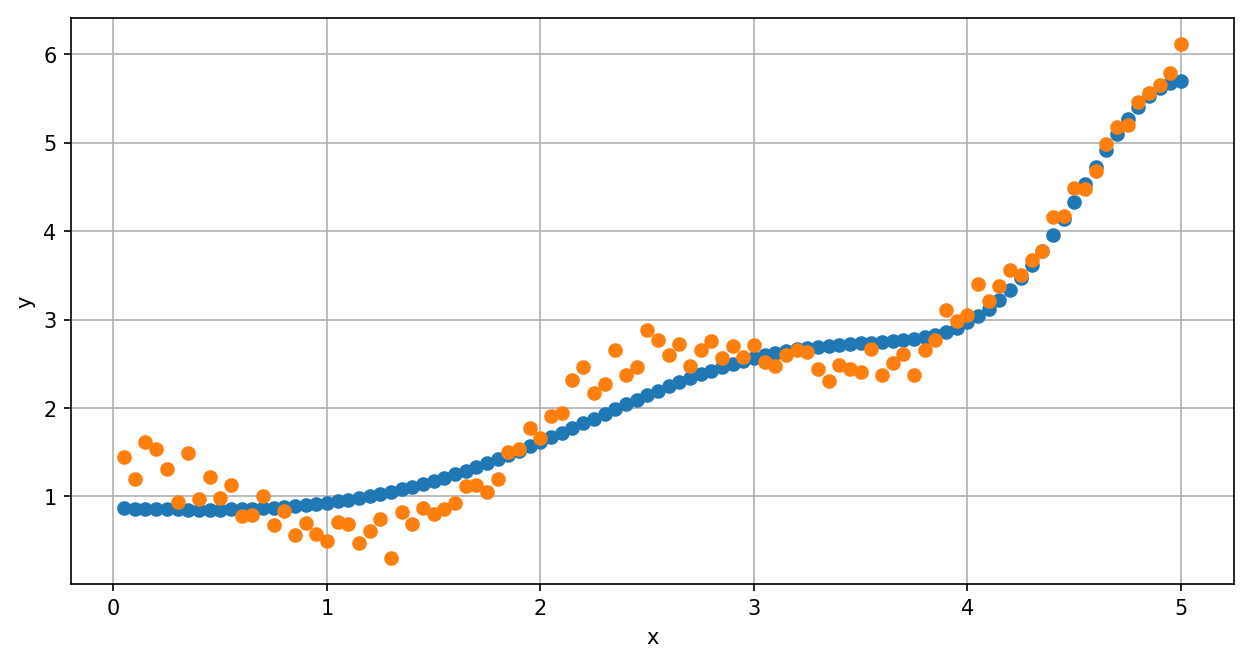

In [61]:
print('MSE =', mean_squared_error(y,Y_est2))
plt.figure(figsize=(10,5))
plt.title('')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.plot (X,Y_est2, 'o')
plt.plot (X,y, 'o')